In [1]:
>>> from text2vec import SentenceModel
>>> m = SentenceModel()
>>> m.encode("如何更换花呗绑定银行卡")


D:\Anaconda\envs\py310code\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hasee\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


2023-11-16 20:29:32.409 | DEBUG    | text2vec.sentence_model:__init__:76 - Use device: cuda


array([-4.43495228e-04, -2.97347546e-01,  8.57901275e-01,  6.90650702e-01,
        3.96458983e-01, -8.48927438e-01, -1.91569403e-01,  8.45486373e-02,
        4.02329296e-01,  3.19662750e-01, -5.57638407e-02,  4.48000908e-01,
        3.13500106e-01, -2.80795932e-01, -5.08029759e-01, -6.67012870e-01,
       -6.74592018e-01,  1.13552034e+00, -3.32654417e-01,  3.99530053e-01,
        5.70722640e-01, -3.85513276e-01, -5.17035961e-01,  7.54722714e-01,
        6.89286068e-02, -3.10941655e-02,  1.99816316e-01, -2.25233398e-02,
       -5.93793035e-01,  1.13403249e+00, -3.81763518e-01,  4.26663250e-01,
       -1.45577359e+00,  5.53026378e-01, -6.70520663e-01,  4.27066654e-01,
        6.30097389e-01, -1.82200849e-01,  1.40885085e-01, -2.66234912e-02,
       -1.72763914e-01, -9.78276283e-02, -1.47475290e+00, -6.00415409e-01,
        2.97164414e-02,  5.77365994e-01, -8.06342363e-01, -7.07512021e-01,
       -9.82230544e-01,  3.50677431e-01, -3.99872482e-01,  3.19298553e+00,
       -4.98136021e-02,  

In [1]:
import os
print(os.getcwd())

D:\KnowlegdgeGraph\code\NLP


## 文本向量化

In [3]:
import text2vec
from tqdm import tqdm
import pandas as pd

# 读取数据
#df = pd.read_excel('D:\\KnowlegdgeGraph\\para模型聚类数据\\句子原始信息\\事故防范和整改措施-分句.xlsx')
df = pd.read_excel('D:\\4.SupervisedLearning\\责任人员分句（逗号和句号）手动.xlsx')
df.fillna(' ', inplace=True) 
#t2v_model = text2vec.SentenceModel("shibing624/text2vec-base-chinese-paraphrase")
t2v_model = text2vec.SentenceModel("shibing624/text2vec-bge-large-chinese")



# 打印进度条     
with tqdm(total=len(df)) as pbar:
    
    # 存储结果    
    results = []
    
    for i, row in df.iterrows():  
        
        # 为每条摘要生成向量
        #embedding = t2v_model.encode(row['事故防范和整改措施'])
        embedding = t2v_model.encode(row['短句子'])
        # 存储结果 
        results.append([row['短句编号'], *embedding])  
        
        # 更新进度条   
        pbar.update(1)
        
    df_result = pd.DataFrame(results, columns=['短句编号'] + [f'embed_{i}' for i in range(embedding.shape[0])]) 

# 保存结果   
#df_result.to_excel('D:\\KnowlegdgeGraph\\para模型聚类数据\\段落向量化结果\\事故防范和整改措施向量化.xlsx', index=False)
df_result.to_excel('D:\\4.SupervisedLearning\\责任短句向量化.xlsx', index=False)

2023-11-17 09:42:49.790 | DEBUG    | text2vec.sentence_model:__init__:76 - Use device: cuda
100%|██████████| 9231/9231 [04:40<00:00, 32.86it/s]


In [73]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm
import time 
import os   

# 读取数据      
df = pd.read_excel('D:\\KnowlegdgeGraph\\TextDataset\\vector\\摘要向量.xlsx')  

# 提取特征        
X = df.drop('事故编号', axis=1).values   

# 起始时间
start = time.time()

# 进行层次聚类      
cluster = AgglomerativeClustering(n_clusters=20, linkage='ward')    
cluster.fit_predict(X)

# 终止时间        
end = time.time()    

# 聚类结果        
labels = cluster.labels_   

# 样本名称      
names = df['事故编号'].values

#结果数据框  
results = pd.DataFrame({'事故编号':names, '分类':labels})     

#输出目录
path = r'D:\\KnowlegdgeGraph\\TextDataset\\vector'  
if not os.path.exists(path):
     os.makedirs(path)

#保存结果表格      
results.to_excel(os.path.join(path,'层次聚类.xlsx'), index = False)   

# 运行时间  
print(f'总共运行了{end-start:.3f}秒')

总共运行了0.005秒


## 无监督聚类评价

In [47]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm
import time 
import os 

# 读取数据      
data = pd.read_excel('D:\\KnowlegdgeGraph\\TextDataset\\vector\\事故发生经过向量化.xlsx', index_col=0, header=0)

# 提取特征        
#X = data.drop('事故编号', axis=1).values   

def hierarchical_clustering(data, n_clusters):
    # 构建聚类模型
    model = AgglomerativeClustering(n_clusters=n_clusters)
    # 进行聚类分析
    labels = model.fit_predict(data)
    # 计算各种评价指标
    silhouette = silhouette_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    # 返回聚类结果和评价指标
    return labels, silhouette, calinski_harabasz, davies_bouldin

# 定义n_clusters参数的范围
n_clusters_range = range(2, 16)
# 初始化结果列表
results = []
# 遍历n_clusters参数的范围
for n_clusters in tqdm(n_clusters_range):
    # 进行聚类分析，并获得聚类结果和评价指标
    labels, silhouette, calinski_harabasz, davies_bouldin = hierarchical_clustering(data, n_clusters)
    # 将聚类结果和评价指标保存到结果列表中
    results.append({
        'n_clusters': n_clusters,
        'labels': labels,
        'silhouette': silhouette,
        'calinski_harabasz': calinski_harabasz,
        'davies_bouldin': davies_bouldin
    })
    
# 将结果列表保存到Excel文件中
pd.DataFrame(results).to_excel('D:\\KnowlegdgeGraph\\TextDataset\\vector\\无监督聚类评价\\事故发生经过clustering_results.xlsx', index=False)

# 输出聚类效果评价指标的表格
df = pd.DataFrame(results)
print(df[['n_clusters', 'silhouette', 'calinski_harabasz', 'davies_bouldin']])

100%|██████████| 13/13 [00:00<00:00, 23.98it/s]

    n_clusters  silhouette  calinski_harabasz  davies_bouldin
0            2    0.032968           6.384865        4.913897
1            3    0.034970           5.587543        4.161612
2            4    0.022117           5.324020        3.996882
3            5    0.019392           5.017086        3.810771
4            6    0.025096           4.841316        3.600927
5            7    0.024572           4.578732        3.482157
6            8    0.021743           4.391592        3.346208
7            9    0.026106           4.254881        3.140853
8           10    0.029670           4.104762        3.107948
9           11    0.028935           3.983836        3.015000
10          12    0.022782           3.856437        3.017419
11          13    0.025694           3.748477        2.957332
12          14    0.027700           3.651766        2.843522


## 聚类结果输出

In [44]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm
import time 
import os 
# 记录程序开始时间
start_time = time.time()
# 读取数据
#data = pd.read_excel('D:\\KnowlegdgeGraph\\para模型聚类数据\\段落向量化结果\\事故防范和整改措施向量化.xlsx', index_col=0, header=0)
data = pd.read_excel('D:\\KnowlegdgeGraph\\para模型聚类数据\\段落向量化结果\\直接原因向量化.xlsx', index_col=0, header=0)
def hierarchical_clustering(data, n_clusters):
    # 构建聚类模型
    model = AgglomerativeClustering(n_clusters=n_clusters)
    # 进行聚类分析
    labels = model.fit_predict(data)
    # 将标签从0~n-1转换为1~n
    labels += 1
    # 返回聚类结果
    return labels

# 定义n_clusters参数的范围
n_clusters_range = range(2, 16)
# 初始化结果字典
results = {}
# 遍历n_clusters参数的范围
for n_clusters in tqdm(n_clusters_range):
    # 进行聚类分析，并获得聚类结果
    labels = hierarchical_clustering(data, n_clusters)
    # 将聚类结果保存到结果字典中
    results[f'分类{n_clusters}'] = labels

# 将聚类结果保存到DataFrame中
df = pd.DataFrame(results, index=data.index)
#df.index.name = '句编号'
df.index.name = '事故编号'
print(df)
#df.to_excel('D:\\KnowlegdgeGraph\\para模型聚类数据\\多参数聚类情况\\事故防范和整改措施聚类情况.xlsx')
df.to_excel('D:\\KnowlegdgeGraph\\para模型聚类数据\\多参数聚类情况\\直接原因聚类情况a.xlsx')

# 计算程序运行时间并打印
end_time = time.time()
run_time = end_time - start_time
print("程序运行时间：{:.3f}秒".format(run_time))

## 计算基于多参数层次聚类的相似度矩阵

In [45]:
import pandas as pd
from tqdm import tqdm
import numpy as np
# 记录程序开始时间
start_time = time.time()
# 读取原始数据
data = pd.read_excel('D:\\KnowlegdgeGraph\\para模型聚类数据\\多参数聚类情况\\直接原因聚类情况a.xlsx', index_col=0, header=0)

# 初始化相似度矩阵
similarity_matrix = pd.DataFrame(index=data.index, columns=data.index, dtype=float)

# 计算相似度矩阵
for i, row in tqdm(enumerate(data.index), desc='计算相似度矩阵', total=len(data.index)):
    for j, col in enumerate(data.index):
        similarity = 0
        for n_clusters in range(2, 16):
            label_i = data.loc[row, f'分类{n_clusters}']
            label_j = data.loc[col, f'分类{n_clusters}']
            if label_i == label_j:
                similarity += n_clusters
        similarity_matrix.loc[row, col] = similarity
        
#矩阵归一化
normalized_matrix = np.divide(similarity_matrix, 119)

# 将相似度矩阵保存到Excel文件中
#similarity_matrix.to_excel('D:\KnowlegdgeGraph\TextDataset\相似度矩阵\直接原因层次聚类相似度矩阵.xlsx', sheet_name='初始相似度')
normalized_matrix.to_excel('D:\KnowlegdgeGraph\para模型聚类数据\基于层次聚类的相似度矩阵\直接原因相似度矩阵b2.xlsx', sheet_name='归一化')

# 计算程序运行时间并打印
end_time = time.time()
run_time = end_time - start_time
print("程序运行时间：{:.3f}秒".format(run_time))

### 绘制相似度分布图

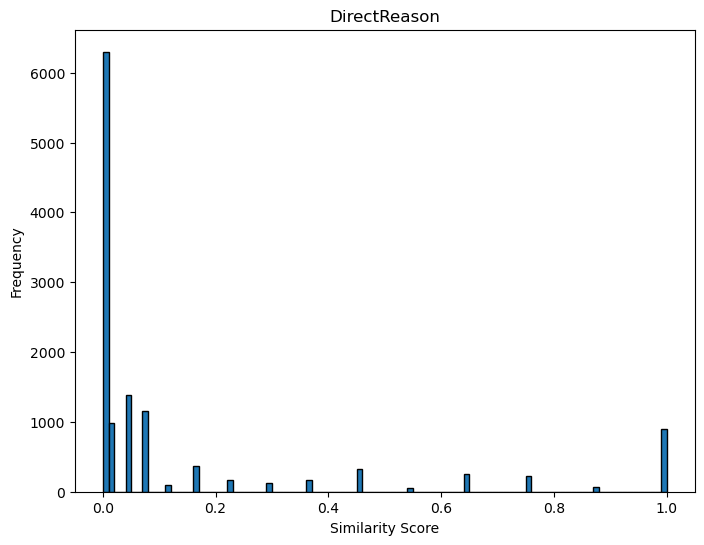

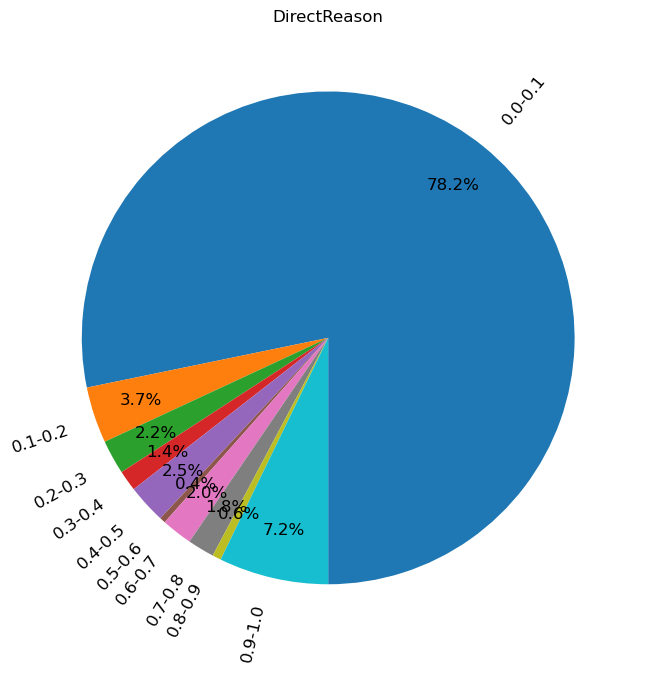

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取数据
data = pd.read_excel(r'D:\KnowlegdgeGraph\para模型聚类数据\基于层次聚类的相似度矩阵\直接原因相似度矩阵.xlsx', index_col=0)

# 取出主对角线以上的数据
#scores = data.where(pd.np.triu(pd.np.ones(data.shape)).astype(bool)).stack().values
#scores = data.where(~pd.np.eye(data.shape[0], dtype=bool)).stack().values
# 生成上三角矩阵掩码
mask = np.triu(np.ones(data.shape), k=1).astype(bool)

# 应用掩码提取主对角线以上的数据
scores = data.where(mask).stack().values

# 绘制直方图
fig, ax = plt.subplots(figsize=(8, 6))
bins = np.arange(0, 1.01, 0.01)
ax.hist(scores, bins=bins, edgecolor='black')
ax.set_xlabel('Similarity Score')
ax.set_ylabel('Frequency')
ax.set_title('DirectReason')
plt.show()

# 绘制扇形图
fig, ax = plt.subplots(figsize=(8, 8))

# 计算每个区间的占比
bins = np.linspace(0, 1, 11)
counts, bins = np.histogram(scores, bins=bins)
counts = counts.astype(float) / counts.sum()

# 为每个区间添加标签
labels = ['{:.1f}-{:.1f}'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]

# 绘制扇形图，显示区间的数值
def autopct_format(value):
    return '{:.1f}%\n({:.0f})'.format(value, value * len(scores))

ax.pie(
    counts, labels=labels, startangle=-90,
    autopct='%.1f%%', labeldistance=1.1,
    pctdistance=0.8, textprops={'fontsize': 12},
    wedgeprops={'width': 1.0},rotatelabels=True,
)
ax.set_title('DirectReason')

plt.show()

## 相似度矩阵提取node和edge文件

In [46]:
import os
import pandas as pd
from tqdm import tqdm

# 读取 Excel 文件
input_file_path = r'D:\KnowlegdgeGraph\para模型聚类数据\基于层次聚类的相似度矩阵\建议追究责任人员相似度矩阵.xlsx'
#input_file_path = r'D:\KnowlegdgeGraph\TextDataset\7texts\直接原因试验.xlsx'
df = pd.read_excel(input_file_path, index_col=0)

# 将小于等于0的元素设置为NaN
df.mask(df <= 0, inplace=True)

# 将矩阵转化为边列表
edges = []
for i, col in enumerate(tqdm(df.columns, desc='Processing edges')):
    for j, row in enumerate(df.index):
        if pd.notna(df.loc[row, col]) and j < i:
            edges.append((row, col, df.loc[row, col]))

# 生成节点信息
nodes = list(df.index)
node_dict = {}
for i, node in enumerate(nodes):
    node_dict[node] = str(i + 1)

# 生成边信息
edge_str = 'source\ttarget\tweight\n'
for i, (n1, n2, weight) in enumerate(tqdm(edges, desc='Generating edges')):
    edge_str += f'{node_dict[n1]}\t{node_dict[n2]}\t{weight}\n'

# 保存节点信息  
node_str = 'id\tlabel\n'
for node, node_id in node_dict.items():
    node_str += f'{node_id}\t"{node}"\n'
node_file_path = r'D:\KnowlegdgeGraph\para模型聚类数据\Vosviewer\输入Vos\建议追究责任人员node.txt'
with open(node_file_path, 'w', encoding='utf-8') as f:
    f.write(node_str)

# 保存边信息
edge_file_path = r'D:\KnowlegdgeGraph\para模型聚类数据\Vosviewer\输入Vos\建议追究责任人员edge.txt'
with open(edge_file_path, 'w', encoding='utf-8') as f:
    f.write(edge_str)

In [47]:
import os
import pandas as pd
from tqdm import tqdm

# 读取 Excel 文件
input_file_path = r'D:\KnowlegdgeGraph\para模型聚类数据\基于层次聚类的相似度矩阵\事故防范和整改措施相似度矩阵.xlsx'
#input_file_path = r'D:\KnowlegdgeGraph\TextDataset\7texts\直接原因试验.xlsx'
df = pd.read_excel(input_file_path, index_col=0)

# 将小于等于0的元素设置为NaN
df.mask(df <= 0, inplace=True)

# 将矩阵转化为边列表
edges = []
for i, col in enumerate(tqdm(df.columns, desc='Processing edges')):
    for j, row in enumerate(df.index):
        if pd.notna(df.loc[row, col]) and j < i:
            edges.append((row, col, df.loc[row, col]))

# 生成节点信息
nodes = list(df.index)
node_dict = {}
for i, node in enumerate(nodes):
    node_dict[node] = str(i + 1)

# 生成边信息
edge_str = 'source\ttarget\tweight\n'
for i, (n1, n2, weight) in enumerate(tqdm(edges, desc='Generating edges')):
    edge_str += f'{node_dict[n1]}\t{node_dict[n2]}\t{weight}\n'

# 保存节点信息  
node_str = 'id\tlabel\n'
for node, node_id in node_dict.items():
    node_str += f'{node_id}\t"{node}"\n'
node_file_path = r'D:\KnowlegdgeGraph\para模型聚类数据\Vosviewer\输入Vos\事故防范和整改措施node.txt'
with open(node_file_path, 'w', encoding='utf-8') as f:
    f.write(node_str)

# 保存边信息
edge_file_path = r'D:\KnowlegdgeGraph\para模型聚类数据\Vosviewer\输入Vos\事故防范和整改措施edge.txt'
with open(edge_file_path, 'w', encoding='utf-8') as f:
    f.write(edge_str)

## 聚类性能指标

In [45]:
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import mutual_info_score

# 我们算法的聚类结果    
labels = [1, 2, 2 ,1, 0, 1, 0, 2, 0, 1]

# ground truth 的聚类结果
gt_labels = [0, 1, 1, 0, 2, 1, 2, 0, 2, 0]

# 计算Rand Index   
rand = rand_score(gt_labels, labels)

# 打印指标    
print(f'Rand Index: {rand}')



Rand Index: 0.7777777777777778


In [12]:
import pandas as pd
from sklearn.metrics.cluster import rand_score

# 读取数据
df = pd.read_excel('D:\\KnowlegdgeGraph\\TextDataset\\vector\\真实分类信息.xlsx')

# 获取正确聚类结果
true_labels = df['真实类编号'].values

# 遍历其他聚类结果
for col in df.columns[1:]:
    labels = df[col].values
    # 计算 Rand Index  
    rand = metrics.adjusted_rand_score(true_labels, labels)
    
    # 打印聚类方法名称和分数      
    print(f'{col}: {rand:.3f}')

真实类编号: 1.000
层次分类5: 0.112
层次分类6: 0.139
层次分类7: 0.066
层次分类8: 0.076
层次分类9: 0.099
层次分类10: 0.085
层次分类11: 0.075
层次分类12: 0.091
层次分类13: 0.094
层次分类14: 0.102
层次分类15: 0.099
层次分类20: 0.072
Kmeans(8,kmeans++): 0.050
Kmeans(8,random): 0.088
Kmeans(5,kmeans++): 0.038
Kmeans(11,kmeans++): 0.036
Kmeans(11,random): 0.063
AffinityPropagation: 0.068
cluster12m: 0.149
cluster13m: 0.149
cluster14m: 0.135
cluster15m: 0.134
cluster16m: 0.136
cluster17m: 0.153
cluster18m: 0.137
cluster19m: 0.117
cluster20m: 0.148
cluster25m: 0.129
cluster30m: 0.097


In [15]:
import pandas as pd
from sklearn import metrics

# 读取数据
df = pd.read_excel('D:\\KnowlegdgeGraph\\TextDataset\\vector\\cluster-m分类信息.xlsx')

# 获取正确聚类结果
true_labels = df['真实类编号'].values

# 遍历其他聚类结果
for col in df.columns[1:]:
    labels = df[col].values
    # 计算 Rand Index  
    rand = metrics.adjusted_rand_score(true_labels, labels)
    
    # 打印聚类方法名称和分数      
    print(f'{col}: {rand:.3f}')

真实类编号: 1.000
cluster12m: 0.149
cluster13m: 0.149
cluster14m: 0.135
cluster15m: 0.134
cluster16m: 0.136
cluster17m: 0.153
cluster18m: 0.137
cluster19m: 0.117
cluster20m: 0.148
cluster25m: 0.129
经过12m: 0.072
直接原因: 0.222
cluster30m: 0.097
random（1）: -0.008
random（2）: -0.002
random（3）: -0.013
random（4）: 0.006
random（5）: 0.004
random（6）: 0.009
random8: -0.004
random5: -0.004
random12: -0.004
random13: 0.002
random14: -0.009
random15: 0.008


## 不同方法的聚类

In [77]:
import pandas as pd
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.cluster import DBSCAN, AffinityPropagation
import os

# 读取数据        
df = pd.read_excel('D:\\KnowlegdgeGraph\\TextDataset\\vector\\摘要向量.xlsx')  

# 提取特征        
X = df.drop('事故编号', axis=1).values   

# 初始化结果表格
results = pd.DataFrame(index = df.index,
   columns=['层次聚类','Kmeans','MeanShift','DBSCAN','AffinityPropagation'])

# 起始时间
start = time.time()

# 进行层次聚类      
#cluster = AgglomerativeClustering(n_clusters=11, linkage='ward')    
#cluster.fit_predict(X)

# Kmeans聚类
kmeans = KMeans().fit(X)  
results['Kmeans'] = kmeans.labels_

# MeanShift聚类
meanshift = MeanShift(bandwidth=1).fit(X) 
results['MeanShift'] = meanshift.labels_ 

# DBSCAN聚类
db = DBSCAN(eps=1, min_samples=5)).fit(X)
results['DBSCAN'] = db.labels_

# AffinityPropagation聚类
af = AffinityPropagation().fit(X)
results['AffinityPropagation'] = af.labels_

# 保存结果
results.to_excel(os.path.join('D:\\KnowlegdgeGraph\\TextDataset\\vector','聚类结果.xlsx'), index=True)

# 运行时间  
print(f'总共运行了{end-start:.3f}秒')

D:\Anaconda\envs\py310code\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\envs\py310code\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


总共运行了-1281.866秒


In [99]:
import pandas as pd
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.cluster import DBSCAN, AffinityPropagation
import os

# 读取数据        
df = pd.read_excel('D:\\KnowlegdgeGraph\\TextDataset\\vector\\摘要向量.xlsx')  

# 提取特征        
X = df.drop('事故编号', axis=1).values   

# 初始化结果表格
results = pd.DataFrame(index = df.index,
   columns=['Kmeans'])

# 起始时间
start = time.time()

# Kmeans聚类
kmeans = KMeans(n_clusters = 8, init = 'random').fit(X)  
results['Kmeans'] = kmeans.labels_

# 保存结果
results.to_excel(os.path.join('D:\\KnowlegdgeGraph\\TextDataset\\vector','kmeans.xlsx'), index=True)

# 运行时间  
print(f'总共运行了{end-start:.3f}秒')

总共运行了-4032.902秒


D:\Anaconda\envs\py310code\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\envs\py310code\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [105]:
import openpyxl
import os

# 定义Excel文件路径和导出txt文件路径
excel_path = r'D:\KnowlegdgeGraph\TextDataset\Vos可视化\聚类结果\摘要聚类试验\基于事故类型的聚类可视化检验.xlsx'
txt_path = r'D:\KnowlegdgeGraph\TextDataset\Vos可视化\聚类结果\摘要聚类试验\摘要map\其他算法基于事故类型可视化聚类'

# 创建txt文件保存路径
if not os.path.exists(txt_path):
    os.makedirs(txt_path)

# 打开Excel文件
workbook = openpyxl.load_workbook(excel_path)

# 遍历Excel文件中的所有表格，并将其导出为txt文件
for sheetname in workbook.sheetnames:
    worksheet = workbook[sheetname]
    txt_filename = os.path.join(txt_path, f'{sheetname}.txt')
    with open(txt_filename, 'w', encoding='utf-8') as f:
        for row in worksheet.iter_rows(values_only=True):
            row_str = '\t'.join(str(cell) for cell in row) + '\n'
            f.write(row_str)